In [175]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from skimage.metrics import normalized_root_mse

In [176]:
dataset = pd.read_csv('Edited_Korea_Original.csv')
dataset

,Measurement date,Station code,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 00:00,102,0.006,0.068,0.002,1.3,77.0,63.0
2,2017-01-01 00:00,103,0.005,0.039,0.002,1.4,70.0,68.0
3,2017-01-01 00:00,104,0.005,0.045,0.003,0.6,73.0,46.0
4,2017-01-01 00:00,105,0.005,0.044,0.004,1.0,81.0,44.0
...,...,...,...,...,...,...,...,...
656995,2019-12-31 23:00,121,0.003,0.042,0.013,0.5,29.0,16.0
656996,2019-12-31 23:00,122,0.003,0.047,0.007,0.4,24.0,15.0
656997,2019-12-31 23:00,123,0.003,0.039,0.003,0.5,19.0,13.0
656998,2019-12-31 23:00,124,0.003,0.035,0.004,0.5,20.0,13.0


In [177]:
df = dataset[dataset['Station code'] == 101].iloc[:,7]
df

0         57.0
25        59.0
50        59.0
75        58.0
100       61.0
          ... 
656875    19.0
656900    19.0
656925    18.0
656950    19.0
656975    15.0
Name: PM2.5, Length: 26280, dtype: float64

In [178]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df).reshape(-1,1))
df1.shape

(26280, 1)

In [179]:
def create_dataset(dataset, time_step=1, out_step = 1):
	dataX, dataY = [], []
	for i in range(0, len(dataset)-time_step-1, out_step):
		dataX.append(dataset[i:(i+time_step)])
		#print(dataX)
		#print(dataset[i:(i+time_step)])
		dataY.append(dataset[(i + time_step):(i + time_step + out_step)].reshape(out_step))
		#print(dataY)
		#print(dataset[(i + time_step):(i + time_step + 9)])
		#break
	return np.array(dataX), np.array(dataY)

In [180]:
time_step = 36
out_step = 3
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size - time_step:len(df1),:]
X_train, y_train = create_dataset(train_data, time_step, out_step)
X_test, y_test = create_dataset(test_data, time_step, out_step)

In [181]:
training_size, test_size

(18396, 7884)

In [182]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6120, 36, 1), (6120, 3), (2628, 36, 1), (2628, 3))

In [183]:
learning_rate = 0.01
model = Sequential()
model.add(LSTM(32, return_sequences = True, input_shape = (X_test.shape[1:])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences = True))
#model.add(Dropout(0.2))
model.add(LSTM(32))
#model.add(Dropout(0.2))
model.add(Dense(y_test.shape[1]))
model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), loss = "mae", metrics = ['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 36, 32)            4352      
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 32)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 36, 32)            8320      
_________________________________________________________________
lstm_26 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 21,091
Trainable params: 21,091
Non-trainable params: 0
_________________________________________________________________


In [184]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 5)

history = model.fit(
    X_train,
    y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 128,
    verbose = 1,
    callbacks = [es_callback]
    )

Epoch 1/100
48/48 [==============================] - 17s 275ms/step - loss: 0.0452 - accuracy: 0.3312 - val_loss: 0.0293 - val_accuracy: 0.2888
Epoch 2/100
48/48 [==============================] - 13s 280ms/step - loss: 0.0283 - accuracy: 0.3394 - val_loss: 0.0239 - val_accuracy: 0.2789
Epoch 3/100
48/48 [==============================] - 15s 323ms/step - loss: 0.0254 - accuracy: 0.3235 - val_loss: 0.0225 - val_accuracy: 0.3174
Epoch 4/100
48/48 [==============================] - 15s 314ms/step - loss: 0.0244 - accuracy: 0.3386 - val_loss: 0.0219 - val_accuracy: 0.3158
Epoch 5/100
48/48 [==============================] - 15s 314ms/step - loss: 0.0227 - accuracy: 0.3500 - val_loss: 0.0212 - val_accuracy: 0.2690
Epoch 6/100
48/48 [==============================] - 12s 258ms/step - loss: 0.0227 - accuracy: 0.3351 - val_loss: 0.0213 - val_accuracy: 0.3018
Epoch 7/100
48/48 [==============================] - 13s 277ms/step - loss: 0.0226 - accuracy: 0.3404 - val_loss: 0.0226 - val_accuracy:

In [185]:
#model.save_weights('lstm_model')

In [186]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [187]:
train_predict.shape, test_predict.shape

((6120, 3), (2628, 3))

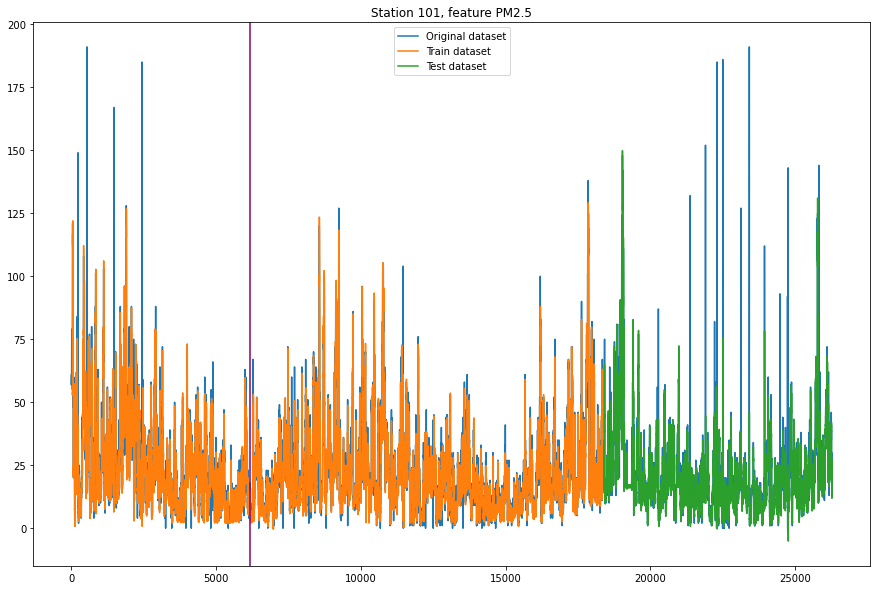

In [188]:
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict.reshape(-1,1))+time_step, :] = scaler.inverse_transform(train_predict).reshape(-1,1)


testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict.reshape(-1,1))+(time_step*2)-time_step:len(df1), :] = scaler.inverse_transform(test_predict).reshape(-1,1)

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

plt.plot(scaler.inverse_transform(df1), label = 'Original dataset')    
plt.plot(trainPredictPlot, label = 'Train dataset')
plt.plot(testPredictPlot, label = 'Test dataset')

plt.axvline(x = len(train_predict) + time_step, color = 'purple')
plt.title(f"Station 101, feature PM2.5")
plt.legend()
plt.show()

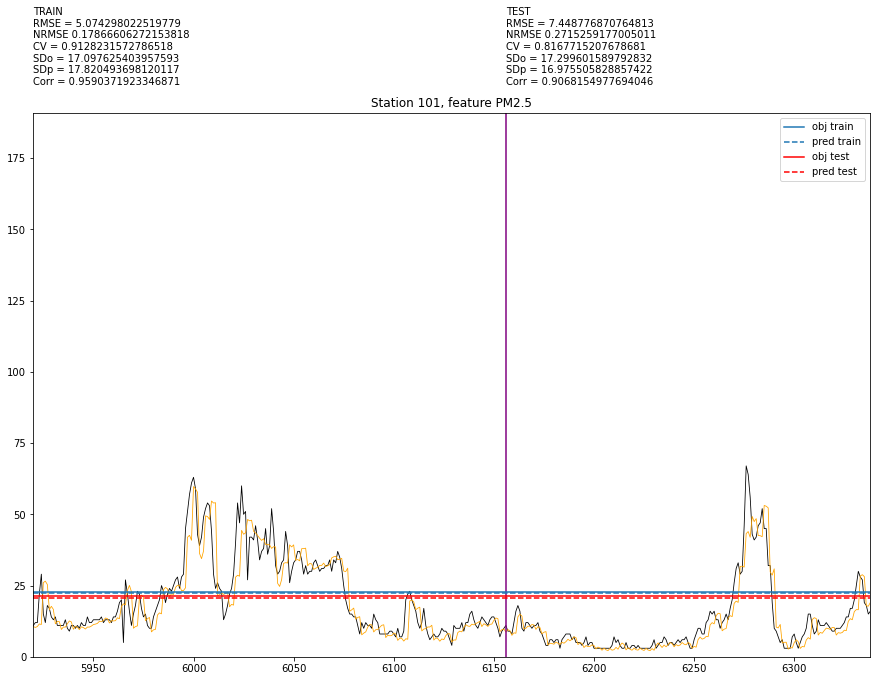

In [189]:
shift = 200


trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict.reshape(-1,1))+time_step, :] = scaler.inverse_transform(train_predict).reshape(-1,1)


testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict.reshape(-1,1))+(time_step*2)-time_step:len(df1), :] = scaler.inverse_transform(test_predict).reshape(-1,1)

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

plt.plot(scaler.inverse_transform(df1), color = 'black', linewidth = 0.8)
plt.plot(trainPredictPlot, color = 'orange', linewidth = 0.8)
plt.plot(testPredictPlot, color = 'green', linewidth = 0.8)

xmin, xmax, ymin, ymax = plt.axis()
plt.axis([len(train_predict) - shift, len(train_predict)+time_step/2 + shift, 0, ymax*0.95])

plt.axvline(x=len(train_predict)+time_step, color = 'purple')
plt.axhline(y = scaler.inverse_transform(y_train).mean(), label = 'obj train')
plt.axhline(y = scaler.inverse_transform(train_predict).mean(), label = 'pred train', linestyle = 'dashed')
plt.axhline(y = scaler.inverse_transform(y_test).mean(), label = 'obj test', color = 'red')
plt.axhline(y = scaler.inverse_transform(test_predict).mean(), label = 'pred test', color = 'red', linestyle = 'dashed')


obj = np.array([j[0] for j in scaler.inverse_transform(y_train)])
pred = np.array([j[0] for j in scaler.inverse_transform(train_predict)])    
plt.text(len(train_predict) - shift, ymax, 
f"""TRAIN
RMSE = {mean_squared_error(obj, pred, squared=False)}
NRMSE {normalized_root_mse(obj, pred)}
CV = {explained_variance_score(obj, pred)}
SDo = {obj.std()}
SDp = {pred.std()}
Corr = {np.corrcoef(np.vstack((obj, pred)))[0][1]}""")


obj = np.array([j[0] for j in scaler.inverse_transform(y_test)])
pred = np.array([j[0] for j in scaler.inverse_transform(test_predict)])  
plt.text(len(train_predict) + time_step, ymax, 
f"""TEST
RMSE = {mean_squared_error(obj, pred, squared=False)}
NRMSE {normalized_root_mse(obj, pred)}
CV = {explained_variance_score(obj, pred)}
SDo = {obj.std()}
SDp = {pred.std()}
Corr = {np.corrcoef(np.vstack((obj, pred)))[0][1]}""")
                                                                

plt.title(f"Station 101, feature PM2.5")
plt.legend()
plt.show()

In [190]:
from pprint import pprint
time_predict = 10
lst_output=[]

x_input = test_data[len(test_data) - time_step:]
temp_input = [x_input.tolist()]


for i in range(time_predict):
    x_input = np.array(temp_input).reshape(-1,time_step,1)
    yhat = model.predict(x_input, verbose=0)
    temp_input[0].extend(yhat.reshape(-1,1).tolist())
    temp_input = [temp_input[0][time_step*-1:]]
    lst_output.extend(yhat.reshape(-1,1).tolist())



Предикт для 30 часов или 1 дней и 6 часов


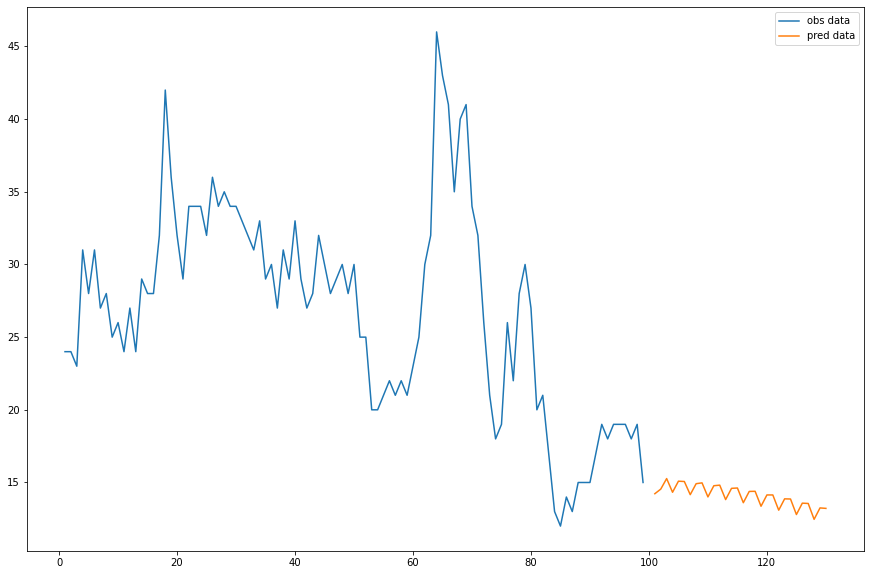

In [191]:
day_new=np.arange(1, 100)
day_pred=np.arange(101, 101 + time_predict*out_step)
print(f"Предикт для {time_predict*out_step} часов или {int(time_predict*out_step/24)} дней и {time_predict*out_step - 24*int(time_predict*out_step/24)} часов")

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
plt.plot(day_new, scaler.inverse_transform(df1)[len(df1) - 99:], label = 'obs data')
plt.plot(day_pred, scaler.inverse_transform(lst_output), label = 'pred data')
plt.legend()
plt.show()